#  Y Dwarf:  MIRISim (LRS slit)

#### This notebook replicates the MIRI LRS slit spectroscopy part of the Y Dwarfs JWST GTO programme (#1189) led by Thomas Roellig. 

**Science Objective:** 
The main science goals of this project are to study Y dwarfs cool atmospheres to obtain information about the
composition and temperature-pressure structure in these objects' atmospheres.
For this goal, we require high contrast spectroscopy using the fixed slit capabilities of MIRI.    
    
**In this notebook**, we create a scene with a point source representing the Y dwarf, add a model atmosphere for its spectral energy distribution (SED), and run through a MIRISim simulation showing the products created at each stage.

**NOTE** this notebook must be started within  the correct anaconda environment in which you have MIRISim installed. This is a prerequisite for using MIRISim, and installation instructions can be found [here](http://miri.ster.kuleuven.be/bin/view/Public/MiricleInstallation).

When launching the notebook, make sure in the right Anaconda environment. i.e. type

<code> source activate miricle </code> 

in the terminal before starting the notebook.

### Steps in this notebook:

0. Import useful python packages
1. Create a Scene
2. Initialise the simulation parameters
3. Run the simulation
4. Examine some of the outputs.  

## Step 0 - Some general python housekeeping
### Import useful python packages

In [1]:
# Import usefull python packages
import numpy as np
import glob                 # glob is used to find the output directory
import os                   # for listing directory contents
from astropy.io import fits # for reading FITS file contents

# Import python packages used to display images inline in the notebook
import matplotlib.pyplot as plt    
from matplotlib import colors,cm
%matplotlib inline       

######################################
# Now import MIRISim specific packages 

# import the configuration file parsers so they can be written to file
from mirisim.config_parser import SimConfig, SimulatorConfig, SceneConfig

# import scene component generators
from mirisim.skysim import Background, sed, Point, Galaxy, kinetics, ExternalSed
from mirisim.skysim import wrap_pysynphot as wS

from mirisim import MiriSimulation         

### Define some common functions 

1) <code>save_to_fits</code> - Used to save the generated scene to a fits file

2) <code>show_outputs</code> - Used in ploting outputs from MIRISim

3) <code>row_based_idx</code> - Used to fill matplotlib subplots by column, not row

4) <code>show_skycubes_spec</code> - Used to plot the spectum in datacubes gernerated by MIRISim

In [2]:
def save_to_fits(scene, light_path, filename='MIRISim_scene.fits', SpatialSampling=0.1, WavelengthRange=None, 
                 WavelengthSampling=0.01):
    """
    Function to save the MIRISim scene to a fits file.
    
    :param filename: Name of file to save - default is "MIRISim_scene.fits"
    :type filename: string       
    
    :param SpatialSampling: Spatial sampling (in arcsec) - default is 0.1 arcseconds
    :type SpatialSampling: float
    
    :param WavelengthRange: Wavelength range to process (in microns) - default is [5, 28] microns
    :type WavelengthRange: array
    
    :param WavelengthSampling: Channel width (in microns) - default is 0.1 arcseconds
    :type WavelengthSampling: float
    
    :rtype: None
    :raises Exception: when light_path parameter not set to MRS or IMA
    """
    
    # Avoids array being extended inside function for mutliple calls. Python gotcha
    if WavelengthRange is None:
        WavelengthRange = [5, 28]
        
    if light_path == 'IMA':
        # IMA Field of view [xmin,xmax],[ymin,ymax] [arcsec]
        FOV = np.array([[-57., 57.],[-57., 57.]])   
    elif light_path == "MRS":
        # MRS Field of view [xmin,xmax],[ymin,ymax] [arcsec]
        FOV = np.array([[-4., 4.],[-4., 4.]])       
    else:
        raise Exception('Acceptable inputs for parameter light_path are [IMA] and [MRS]')
    
    # overwrite = True enables overwriting of any previous version of the fits file
    # with the same name as that given in the writecube command
    scene.writecube(cubefits = filename,
                    FOV = FOV, time = 0.0,
                    spatsampling = SpatialSampling,
                    wrange = WavelengthRange,
                    wsampling = WavelengthSampling,
                    overwrite = True) 

In [3]:
def show_outputs(MIRISim_outputdir,output_type):
    """
    Plot the specified channel of the MIRISim outputs
    :param MIRISim_outputdir:  
        name of the date-labelled dir. holding the MIRISIM outputs
    :param output_type: 
        type of output to process 
        (e.g. illum_models, det_images or skycubes)
    """
    
    infits = glob.glob('{}/{}/*.fits'.format(MIRISim_outputdir,output_type))[0]
    
    hdulist = fits.open(infits)
    
    if output_type.lower() == 'skycubes': 
        hdu_index = 0
        datashape = hdulist[hdu_index].data.shape
        central_chan = datashape[0]//2
        
        plt.imshow(hdulist[hdu_index].data[central_chan,:,:],
           origin = 'lower', interpolation = 'nearest',cmap = cm.viridis)
        plt.title('channel {} of {}'.format(central_chan,infits.split('/')[-1]))
        plt.xlabel(hdulist[hdu_index].header['ctype1'])
        plt.ylabel(hdulist[hdu_index].header['ctype2'])
    else:
        hdu_index = 1
        if len(hdulist[hdu_index].data.shape) > 2:
            integ,frames,nx,ny = hdulist[hdu_index].data.shape
            image = hdulist[hdu_index].data[integ-1,frames-1,:,:]
        else:
            image = hdulist[hdu_index].data
            
        
        plt.imshow(image, origin = 'lower',cmap = cm.viridis,interpolation='nearest')
        plt.title('{}'.format(infits.split('/')[-1]))
        plt.xlabel('Along Slice Direction')
        plt.ylabel('Wavelength Direction')

    plt.colorbar()

In [4]:
def row_based_idx(num_rows, num_cols, idx):
    """
    Function to fill matplotlib subplots by column, not row
    """
    return np.arange(1, num_rows*num_cols + 1).reshape((num_rows, num_cols)).transpose().flatten()[idx-1]

In [5]:
def show_skycubes_spec(directory_list):
    """
    Plots the average MIRISim spectra for each FOV from the 12 skycubes generated from 
    the Short, Medium and Long dispersers
    :param directory_list:  
        List containing the three output directories for MRS simulation results
    """    
    
    # Define subplot grid for the MRS skycubes
    num_cols = 3 
    num_rows = 4             

    maxfigs = 12
    fig = plt.figure(figsize=(10,3*num_rows))
    i=0

    for num, outputdir in enumerate(directory_list):
        outputDirContents = os.listdir(outputdir)

        directories = [name for name in outputDirContents if os.path.isdir(os.path.join(outputdir,name))]

        filenames_skycube = glob.glob('{}/{}/*.fits'.format(outputdir,'skycubes')) # Get skycube file

        for skycube_file in filenames_skycube:

            hdu = fits.open(skycube_file)        # Open file 
            data_cube = hdu[0].data              # Get data 
            #datashape = hdu[0].data.shape       # Get data shape - Z, X, Y  

            # Get the wavelength data 
            wav =  hdu[1].data

            # Find the max and min wavelelgths for the output cube
            vmin = wav[0]
            vmax = wav[-1]       
            #print(np.round(vmin,2), np.round(vmax,2))

            # Get the flux data from an average of the cube
            spectrum = data_cube.mean(axis=(1, 2))  

            # Plot the spectrum - Each colum = short, medium, long
            plt.subplot(num_rows, num_cols, row_based_idx(num_rows, num_cols,i+1))
            plt.plot(wav, spectrum)                                       
            #plt.xticks([])  # help clean up the plot
            plt.yticks([])   # help clean up the plot 
            i+=1    

    fig.add_subplot(111, frame_on=False)

    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xlabel("Wavelength (microns)", fontsize=14)
    plt.ylabel("Flux (data units)", fontsize=14)

    fig.suptitle('    Short                           Medium                           Long', y=1.02, fontsize=18)

    fig.tight_layout()

    plt.show()
    plt.close()    

### Set flags for saving the MIRISim scene to a fits file - default is False 

We select false as the default as 1) a fits file of the scene is not necessary to run mirisim; 2) this step can take a long time to run; 3) once a scene has been saved as a fits file one this step is not necessary.

In [6]:
save_scene_as_fits = False

## Step 1 - Create a Scene - this represents your science observation

Each scene should include at minimum: 1) A background level; 2) A science source

The scene created below consists of a low level background, a point source representing the Y dwarf. 

### Create a low level background for the scene

In [7]:
bg = Background(level='low',gradient=1., pa=5.)

2020-03-06 14:05:28,843 - INFO - Initializing Background


### Create the Y Dwarf instance

#### 1) First import the Y Dwarf SED from an external file

Here the Y dwarf SED is taken from the T/Y dwarf models by Morler et al. 2014.  The specific model used here has T=450K, log g= 4.5, h = 0.5, f_sed=5, and scaled in brightness to replicate the JWST ETC and APT tutorial produced for the ESA JWST Masterclass by S. Kendrew. 

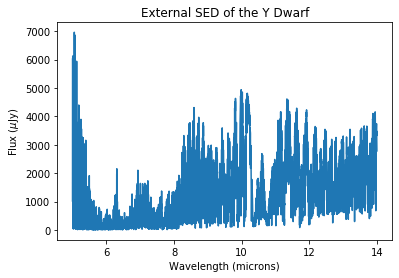

In [8]:
# Use: sedfile =  ExternalSed('extsed.txt') # filepath, columns 'wavelength' [microns] and 'flux' [muJy]
ydwarf_sed = ExternalSed(sedfile = 'morley_ydwarf_mirisim.txt') 

# For zooming in on spectral ranges
l_min = 5 #micron
l_max = 14 #micron
sp_min = np.abs(ydwarf_sed.Lam-l_min).argmin()
sp_max = np.abs(ydwarf_sed.Lam-l_max).argmin()

# Plot the spectrum of the Y dwarf for reference
fig = plt.figure(figsize=(8, 6))
ax = plt.subplots()[1]  
ax.plot(ydwarf_sed.Lam[sp_min:sp_max], ydwarf_sed.fLam[sp_min:sp_max])   
ax.set_xlabel("Wavelength (microns)")  
ax.set_ylabel("Flux ($\mu$Jy)")  
ax.set_title("External SED of the Y Dwarf")  
plt.close(fig)

### 2) Initialize a Y Dwarf object - located in the LRS slit.  

In this example we are assuming the Y dwarf is a point source.

In [9]:
# Create a single point source
ydwarf_slit_ps = Point(Cen=[0,0])

2020-03-06 14:05:29,940 - INFO - Initializing Point


### 3) Then attach the SED to an object  

In [10]:
# Attached the SED
ydwarf_slit_ps.set_SED(ydwarf_sed)
                       
# Add created pointsource to the compound target list called 'stars' for creating a scene
slit_star = ydwarf_slit_ps

# For writing to scene.ini file
targetlist = [slit_star]

### From the components, create a scene

To create a scene adding together the background and target

In [11]:
scene = bg +  slit_star

### Export the scene to an ini file and FITS file (optional)

Export scene to an ini file (for future use), or a FITS file to be visualised. This stage is not necessary if running mirisim in a notebook.

Exporting to a FITS file requires specifying a number of additional parameters such as the Field of view, required spectral sampling, etc. They're described in more detail below. For large fields of view, and/or small spectral channels, which create large FITS files, writing to a FITS file can take a while (few minutes)


In [12]:
# Used to run MIRISim within notebook
scene_config = SceneConfig.makeScene(loglevel=0,
                                    background=bg,
                                    targets = targetlist)

# Export to ini file - not necessary if runing mirisim in notebook
os.system('rm -fr LRS_YDwarf_scene.ini')      # Remove previous version of .ini file
scene_config.write('LRS_YDwarf_scene.ini')

##### OPTIONAL - Save the generated scene to a fits file - Note this step can take a long time depending on the chosen parameters

In [13]:
# Export to FITS file - Optional 
if save_scene_as_fits == True:
    save_to_fits(scene, light_path="LRS", filename='MIRISim_scene.fits')

## Initialize the LRS Simulation Parameters

This is where the parameters for the LRS simulation get set.  These should be set to match the desired MIRI LRS observation setup. 

**Note** MIRISim must have parameters set for all light paths in <code>SimConfig.makeSim</code> this includes some parameters not relevant to the MRS simulation defined in this file. Those relevant not being used in this simulation are labeled with <code> NOT USED HERE </code> in the comments of each line **and should not be deleted**.

### Y Dwarf LRS observation set up:

Here we want to simulate a spectrum covering the LRS wavelength range.  

1. Dither = 2pt 
2. Read out mode = <code>FAST</code> selected based on best practices. 

####  Groups - Integrations
120 groups and 10 integrations

To modify this simulation for other observation setups the following parameters in sim_config should be changed:

1) <code>ima_frames</code>
2) <code>ima_integrations</code>
3) <code>ima_exposures</code>

In [14]:
sim_config = SimConfig.makeSim(
    name = 'MIRI_LRSslit_dither_YDwarf',    # name given to simulation
    scene = 'LRS_YDwarf_scene.ini',         # name of scene file to input
    rel_obsdate = 1.0,                      # relative observation date (0 = launch, 1 = end of 5 yrs)
    
    POP = 'IMA',                        # Component on which to center (Imager or MRS)
    ConfigPath = 'LRS_SLIT',            # Configure the Optical path 
    
    Dither = True,                      # Nod along the slit
    StartInd = 1,                       # start index for dither pattern 
    NDither = 2,                        # number of dither positions 
    DitherPat = 'lrs_recommended_dither.dat', # dither pattern to use
    

    ima_exposures = 1,            # number of exposures
    ima_integrations = 10,        # number of integrations
    ima_frames = 120,             # number of groups (for MIRI, # Groups = # Frames)
    ima_mode = 'FAST',            # Imager read mode (default is FAST ~ 2.3 s)
    filter = 'P750L',             # Imager Filter to use
    readDetect = 'FULL',          # Portion of detector to read out
    
    disperser = 'SHORT',        # [NOT USED HERE]
    detector = 'SW',            # [NOT USED HERE]
    mrs_mode = 'SLOW',          # [NOT USED HERE]
    mrs_exposures = 10,         # [NOT USED HERE]
    mrs_integrations = 3,       # [NOT USED HERE]
    mrs_frames = 10             # [NOT USED HERE]
    
)

### Optional: Export the simulation setup to a file

Not necessary as saved in mirisim output in the date stamped output directory. Included here as naming each file explicitly for record keeping.  

In [15]:
os.system('rm -fr MIRI_LRSslit_dither.ini')
sim_config.write('MIRI_LRSslit_dither.ini')

## Run the simulation

Now that the scene and the setup of the simulation have been set, we can run the simulation.

The last step is to setup the defaults for internal things like calibration data products (CDPs).

In [16]:
# Get the simulation configuration perameters using the default setup
simulator_config = SimulatorConfig.from_default()

In [17]:
# Run simulation
mysim = MiriSimulation(sim_config,scene_config,simulator_config)
mysim.run()   

2020-03-06 14:05:30,022 - INFO - MIRISim version: 2.2.0
2020-03-06 14:05:30,023 - INFO - MIRI Simulation started.
2020-03-06 14:05:30,024 - INFO - Output will be saved to: 20200306_140530_mirisim
2020-03-06 14:05:30,025 - INFO - Storing configs in output directory.
2020-03-06 14:05:34,507 - INFO - Reading cosmic ray properties from parameter file /Users/ojones/anaconda3/envs/miricle/lib/python3.6/site-packages/miri/simulators/scasim/cosmic_ray_properties.py
2020-03-06 14:05:34,587 - INFO - Reading detector properties from parameter file /Users/ojones/anaconda3/envs/miricle/lib/python3.6/site-packages/miri/simulators/scasim/detector_properties.py
2020-03-06 14:05:34,961 - INFO - Storing dither pattern in output directory.
2020-03-06 14:05:34,976 - INFO - Using $CDP_DIR for location of CDP files: /Users/ojones/Data/MIRI_testing
2020-03-06 14:05:34,977 - INFO - Setting up simulated Observation, with following settings:
2020-03-06 14:05:34,978 - INFO - Configuration Path: LRS_SLIT
2020-03-

2020-03-06 14:05:43,179 - INFO - 	Poisson noise simulation turned ON.
2020-03-06 14:05:43,180 - INFO - 	Read noise simulation turned ON.
2020-03-06 14:05:43,181 - INFO - 	Reference pixels simulation turned ON.
2020-03-06 14:05:43,181 - INFO - 	Bad pixels simulation turned ON.
2020-03-06 14:05:43,182 - INFO - 	Dark current simulation turned ON.
2020-03-06 14:05:43,183 - INFO - 	Flat-field simulation turned ON.
2020-03-06 14:05:43,184 - INFO - 	Amplifier bias and gain turned ON.
2020-03-06 14:05:43,185 - INFO - 	Detector non-linearity effects turned ON.
2020-03-06 14:05:43,186 - INFO - 	Detector drift effects turned ON.
2020-03-06 14:05:43,187 - INFO - 	Detector latency effects turned ON.
2020-03-06 14:05:43,188 - INFO - Creating a new detector object for 1024 rows x 1024 columns.
2020-03-06 14:05:43,193 - INFO - Reading 'MASK' model from '/Users/ojones/Data/MIRI_testing/fitsCDP/MIRI_FM_MIRIMAGE_MASK_07.02.01.fits'
2020-03-06 14:05:43,307 - INFO - Reading 'GAIN' model from '/Users/ojones

2020-03-06 14:15:17,191 - INFO - Reading 'PIXELFLAT' model from '/Users/ojones/Data/MIRI_testing/fitsCDP/MIRI_FM_MIRIMAGE_P750L_PIXELFLAT_07.01.01.fits'
2020-03-06 14:15:17,265 - WARNING - Could not find exact match for pixel flat-field for detector MIRIMAGE with FAST mode with filter='P750L'. An alternative is being used.
2020-03-06 14:15:17,361 - INFO - Reading 'LINEARITY' model from '/Users/ojones/Data/MIRI_testing/fitsCDP/MIRI_FM_MIRIMAGE_LINEARITY_06.02.00.fits'
2020-03-06 14:15:17,647 - INFO - Reading 'READNOISE' model from '/Users/ojones/Data/MIRI_testing/fitsCDP/MIRI_FM_MIRIMAGE_FAST_READNOISE_07.01.00.fits'
2020-03-06 14:15:17,711 - INFO - Creating exposure_data with 1280 rows x 1032 columns plus 120 groups and 10 ints.
2020-03-06 14:15:17,822 - INFO - Simulating 10 integrations.
2020-03-06 14:15:17,934 - INFO - Simulating 120 groups for integration 1.
2020-03-06 14:15:45,477 - INFO - Simulating 120 groups for integration 2.
2020-03-06 14:16:13,388 - INFO - Simulating 120 grou

## Examine some of the results

Now that the MIRISim simulation has completed, lets examine the results. 


The first thing to note is that the outputs are placed in a date-labelled directory taking the form  <code> YYYYMMDD_hhmmss_mirisim</code>.  The name of the output directory is given in the last line of the MIRISim log above.  Because the output directory is date-labelled, we can quantify which was the most recent run of MIRISim, and find its output directory using <code>glob.glob</code>

### The results of the simulation are contained in the most recent directory. 

In [18]:
outputdir = sorted(glob.glob('*_*_mirisim'),key=os.path.getmtime)[-1]    #[-1] takes the last entry found

outputDirContents = os.listdir(outputdir)

directories = [name for name in outputDirContents if os.path.isdir(os.path.join(outputdir,name))]
files = [name for name in outputDirContents if not os.path.isdir(os.path.join(outputdir,name))]

print('The subdirectories in the output directory are:\n{}'.format(directories))
print('The files in the output directory are:\n{}'.format(files))

The subdirectories in the output directory are:
['det_images', 'illum_models']
The files in the output directory are:
['lrs_recommended_dither.dat', 'mirisim.log', 'scene.ini', 'simulation.ini', 'simulator.ini']


### Viewing an illumination model

Below shows an example of the output illumination model.  The illumination model is the representation of the light from the scene that is hitting the detector. It has all of the transformations and distortions (and for spectroscopy, the dispersions) applied to the light from the scene. This is then input to the detector simulator which applies the sensitivity models, cosmic rays and noise sources of the instrument.  

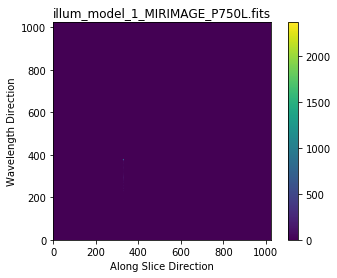

In [19]:
show_outputs(outputdir,'illum_models')

## Viewing the final detector image

The detector images are the final output of MIRISim, and have data structures and formatting consistent with what will come from MIRI itself. The data format is JWST pipeline ready.  Below an example image of the last frame of the last integration is shown. The units are <code>DN</code>.

Additionally, below the FITS header information for the SCIENCE extension is listed

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                 1032                                                  
NAXIS2  =                 1024                                                  
NAXIS3  =                  120                                                  
NAXIS4  =                   10                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SCI     '           / extension name                                 
                                                                                
        Information about the coordinates in the file                           
                            

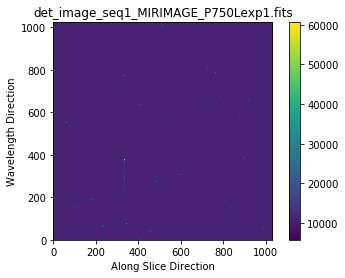

In [20]:
show_outputs(outputdir,'det_images')

infits = glob.glob('{}/det_images/*.fits'.format(outputdir))[0]
hdulist = fits.open(infits)
hdulist[1].header

## The outputs of MIRISim can now be run through the JWST pipeline see:
###  https://jwst-docs.stsci.edu/jwst-data-reduction-pipeline and https://jwst-pipeline.readthedocs.io/en/stable/